In [38]:
import flv_utils as flv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import os

In [2]:
def get_trace_signal(data: dict, includ: list[int]):
    traces = data['neuron_traces'][includ]
    trace_mean = np.mean(traces, axis=1, keepdims=True)
    signal = np.std(traces / trace_mean, axis=1)
    return signal

def get_F_percentile(data: dict, includ: list[int]):
    traces = data['neuron_traces'][includ]
    trace_mean = np.mean(traces, axis=1, keepdims=True)
    F_p = {}
    for p in np.arange(0,101,2):
        F_p[p] = np.percentile(traces, p, axis=1)
    return F_p

In [229]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(data, row_labels, col_labels, 
               figsize=(16,3), xrotation=90,
               xlabel='Neuron Classes', 
               ylabel='Experimental\nConditions', 
               title=None,
               cmap='viridis', clim=[0,4], 
               significant_mask=None,
               sig_dict=None):
    """
    Create a heatmap with custom tick labels and colorbar.
    
    Parameters
    ----------
    data : 2D numpy array
        Heatmap values
    row_labels : list of str
        Y-axis labels
    col_labels : list of str
        X-axis labels (neuron classes)
    figsize : tuple
        Figure size
    xrotation : int
        Rotation angle for x-axis labels
    xlabel, ylabel, title : str
        Axis and plot labels
    cmap : str
        Colormap
    clim : list [vmin, vmax]
        Color limits for the heatmap
    significant_mask : 2D boolean array, optional
        Mark individual cells with red borders
    sig_dict : dict, optional
        {col_label: bool} for marking significant columns (asterisks on xticklabels)
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the heatmap
    im = ax.imshow(data, cmap=cmap, aspect=1, vmin=clim[0], vmax=clim[1])
    
    # Add red borders for significant cells
    if significant_mask is not None:
        for i in range(significant_mask.shape[0]):
            for j in range(significant_mask.shape[1]):
                if significant_mask[i, j]:
                    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                         fill=False, edgecolor='red', linewidth=3)
                    ax.add_patch(rect)
    
    # Tick positions
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    
    # Mark significant columns with asterisk if sig_dict provided
    if sig_dict is not None:
        xticklabels = []
        for label in col_labels:
            if sig_dict.get(label, False):
                xticklabels.append(f"{label}*")
            else:
                xticklabels.append(label)
        ax.set_xticklabels(xticklabels, fontsize=9)
    else:
        ax.set_xticklabels(col_labels, fontsize=9)
    
    ax.set_yticklabels(row_labels, fontsize=9)
    
    # Rotate x-axis labels if needed
    plt.setp(ax.get_xticklabels(), rotation=xrotation, ha="right", rotation_mode="anchor")
    
    # Add colorbar
    vmin, vmax = im.get_clim()
    ticks = np.linspace(vmin, vmax, 5) 
    cbar = plt.colorbar(im, ax=ax, format='%.1f', ticks=ticks, extend='neither')
    cbar.ax.tick_params(labelsize=10)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Optional grid
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    return fig, ax, cbar

In [20]:
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/om_fits_120/2025-09-01'
nc = 'RIB'
condition = 'sparse_food'
path_output = f'{full_model_dir}/{nc}/{condition}.h5'
result = flv.h5_to_dict(path_output)
result.keys()

dict_keys(['CePNEMOutput', 'beh', 'beh_unnorm', 'datasets', 'mad_vals', 'ys', 'ys_unnorm'])

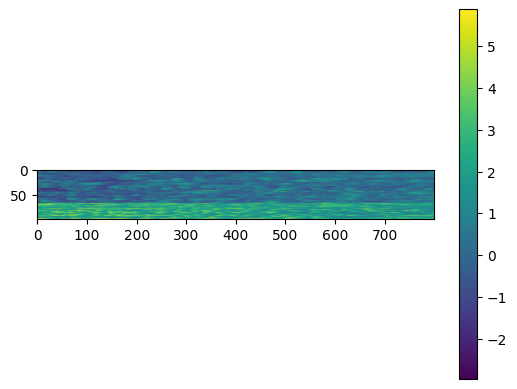

In [23]:
plt.imshow(ys)
plt.colorbar()

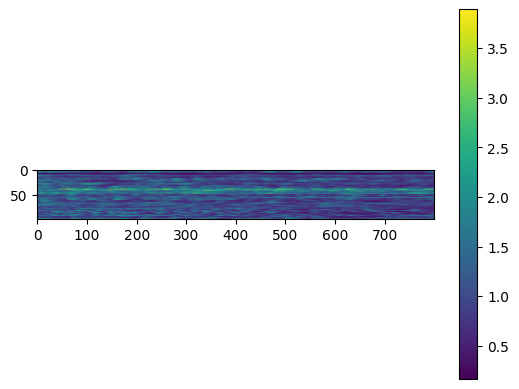

In [24]:
plt.imshow(ys_unnorm)
plt.colorbar()

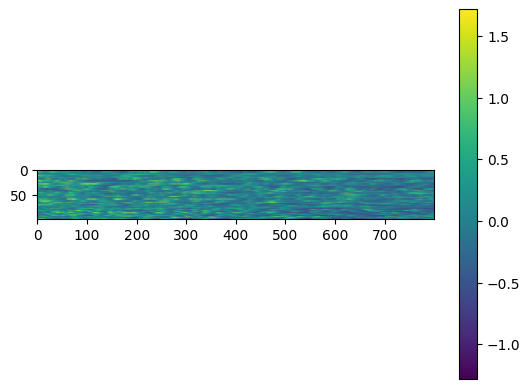

In [29]:
ys_sub_median = ys_unnorm - np.median(ys_unnorm, axis=1, keepdims=True)
plt.imshow(ys_sub_median)
plt.colorbar()

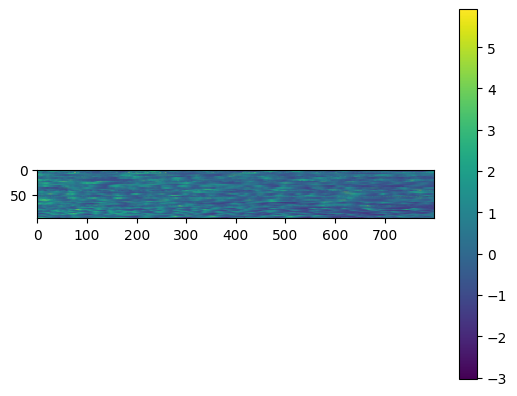

In [31]:
ys_zscore = ys_sub_median / np.std(ys_sub_median, axis=1, keepdims=True)
plt.imshow(ys_zscore)
plt.colorbar()

In [70]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_outliers(arr, std_threshold=4):
    """
    Interpolates values in a 2D numpy array that are more than std_threshold 
    standard deviations away from the mean of their respective row.
    
    Parameters:
    arr (numpy.ndarray): 2D input array
    std_threshold (float): Standard deviation threshold (default: 4)
    
    Returns:
    numpy.ndarray: Array with outliers interpolated
    """
    result = arr.copy()
    
    for i in range(arr.shape[0]):
        row = arr[i, :]
        row_mean = np.mean(row)
        row_std = np.std(row)
        
        # Skip if standard deviation is zero (all values are the same)
        if row_std == 0:
            continue
            
        # Find outliers: values more than std_threshold standard deviations away
        outlier_mask = np.abs(row - row_mean) > std_threshold * row_std
        
        if np.any(outlier_mask):
            # Get indices of non-outlier values for interpolation
            valid_indices = np.where(~outlier_mask)[0]
            outlier_indices = np.where(outlier_mask)[0]
            
            # Need at least 2 valid points for interpolation
            if len(valid_indices) < 2:
                # If we don't have enough valid points, replace with row mean
                result[i, outlier_indices] = row_mean
            else:
                # Create interpolation function using valid points
                valid_values = row[valid_indices]
                interp_func = interp1d(valid_indices, valid_values, 
                                     kind='linear', fill_value='extrapolate')
                
                # Interpolate outlier values
                result[i, outlier_indices] = interp_func(outlier_indices)
    
    return result

In [72]:
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/om_fits_120/2025-09-01'
all_conditions = ['dense_food', 'sparse_food', 'diacetyl', 'just_fed', 'fasted', 'starved', 'octanol', 'heat_stim', 'gfp']

dict_signal = dict()
dict_F5  = dict()
dict_F10 = dict()
dict_F90 = dict()
fig4_neuron_classes_found = []

for nc in flv.fig4_neuron_classes:
    if not os.path.isdir(f'{full_model_dir}/{nc}'):
        print(f'{nc} not found')
        continue
    
    dict_signal[nc] = dict()
    dict_F5[nc] = dict()
    dict_F10[nc] = dict()
    dict_F90[nc] = dict()
    fig4_neuron_classes_found.append(nc)
    
    for condition in all_conditions:
        
        if condition == 'diacetyl':
            path_output = f'{full_model_dir}/{nc}/just_fed.h5'
        else:
            path_output = f'{full_model_dir}/{nc}/{condition}.h5'
            
        if not os.path.isfile(path_output):
            print(f'{nc} not found for {condition}')
            continue
            
        result = flv.h5_to_dict(path_output)

        # Compute F10 baseline activity from unnormalized ratiometric neural traces
        ys_unnorm = result['ys_unnorm']
        dict_F5[nc][condition]  = np.percentile(ys_unnorm, 5, axis=1)
        dict_F10[nc][condition] = np.percentile(ys_unnorm, 10, axis=1)
        dict_F90[nc][condition] = np.percentile(ys_unnorm, 90, axis=1)

        # Compute neural dynamics as variance of median-subtracted, std-interpolated traces
        ys_sub_median = ys_unnorm - np.median(ys_unnorm, axis=1, keepdims=True)
        ys_sub_median = interpolate_outliers(ys_sub_median, std_threshold=4)
        dict_signal[nc][condition] = np.std(ys_sub_median, axis=1, keepdims=True).flatten()

AIA not found
AVL not found
RIF not found
RIR not found
RIP not found
SAADR not found
SMBD not found
SIAV not found
SIAD not found
SIBV not found
SIBD not found
AFD not found
I4 not found
I5 not found
I6 not found


In [225]:
from scipy.stats import kruskal

def kruskal_wallis_dict(dict_signal, drop_conditions=None):
    """
    Compute Kruskal-Wallis test for each nc across conditions.
    
    Parameters
    ----------
    dict_signal : dict
        Nested dictionary {nc: {condition: list_of_values}}
    drop_conditions : list or set, optional
        Conditions to exclude from the test
    
    Returns
    -------
    pvals : dict
        {nc: p-value} for each nc
    """
    if drop_conditions is None:
        drop_conditions = set()
    else:
        drop_conditions = set(drop_conditions)
    
    pvals = {}
    for nc, cond_dict in dict_signal.items():
        # keep only allowed conditions with non-empty data
        data_groups = [
            values for cond, values in cond_dict.items()
            if cond not in drop_conditions and len(values) > 0
        ]
        
        if len(data_groups) > 1:  # need ≥2 groups
            stat, pval = kruskal(*data_groups)
            pvals[nc] = pval
        else:
            pvals[nc] = None  # not enough groups
    
    return pvals


import numpy as np

def benjamini_hochberg_dict(pvals_dict, alpha=0.01):
    """
    Benjamini–Hochberg FDR correction with significance at level `alpha`.

    Parameters
    ----------
    pvals_dict : dict
        {key: p-value or None}
    alpha : float, optional
        FDR level (default 0.05)

    Returns
    -------
    adj_pvals : dict
        {key: BH-adjusted p-value (or None if input was None)}
    significant : dict
        {key: bool or None}  # True if adj_p <= alpha; None if input was None
    """
    # Extract finite p-values
    items = [(k, p) for k, p in pvals_dict.items() if p is not None]
    if not items:
        # nothing to correct
        return ({k: None for k in pvals_dict},
                {k: None for k in pvals_dict})

    keys = [k for k, _ in items]
    pvals = np.array([p for _, p in items], dtype=float)

    # Sort ascending
    order = np.argsort(pvals)
    p_sorted = pvals[order]
    m = len(p_sorted)

    # Raw BH factors and adjusted p-values
    bh_raw = p_sorted * m / np.arange(1, m + 1)

    # Enforce monotonicity from largest to smallest (cumulative min)
    bh_adj = np.minimum.accumulate(bh_raw[::-1])[::-1]
    bh_adj = np.clip(bh_adj, 0.0, 1.0)

    # Map back to original (unsorted) order of the non-None items
    adj_unsorted = np.empty_like(bh_adj)
    adj_unsorted[order] = bh_adj

    # Build full dicts (preserve None entries)
    adj_pvals = {k: None for k in pvals_dict}
    significant = {k: None for k in pvals_dict}
    for k, adj_p in zip(keys, adj_unsorted):
        adj_pvals[k] = float(adj_p)
        significant[k] = bool(adj_p <= alpha)

    return adj_pvals, significant


def bonferroni_dict(pvals_dict, alpha=0.05):
    """
    Bonferroni correction with significance at level `alpha`.

    Parameters
    ----------
    pvals_dict : dict
        {key: p-value or None}
    alpha : float, optional
        Family-wise error rate (default 0.05)

    Returns
    -------
    adj_pvals : dict
        {key: Bonferroni-adjusted p-value (or None if input was None)}
    significant : dict
        {key: bool or None}  # True if adj_p <= alpha; None if input was None
    """
    # Extract finite p-values
    items = [(k, p) for k, p in pvals_dict.items() if p is not None]
    if not items:
        return ({k: None for k in pvals_dict},
                {k: None for k in pvals_dict})

    m = len(items)
    adj_pvals = {k: None for k in pvals_dict}
    significant = {k: None for k in pvals_dict}

    for k, p in items:
        p_adj = min(p * m, 1.0)
        adj_pvals[k] = float(p_adj)
        significant[k] = bool(p_adj <= alpha)

    return adj_pvals, significant

In [59]:
def dict_to_arr(input_dict: dict,
                all_conditions,
                all_neuron_classes):
    # turn into a single matrix for plotting
    n_conditions = len(all_conditions)
    n_neuron_class = len(all_neuron_classes)
    arr = np.full((n_conditions, n_neuron_class), np.nan)
    
    for (idx_cond, condition) in enumerate(all_conditions):  # each row of arr
        for (idx_neu, neuron_class) in enumerate(all_neuron_classes):  # each column of arr
            arr[idx_cond, idx_neu] = np.nanmedian(input_dict[neuron_class][condition])  # take the median of all traces

    return arr

In [274]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_heatmap_transposed_with_padj(
    data,                    # shape: (n_neurons, n_conditions)
    row_labels,              # neuron classes (len = n_neurons)
    col_labels,              # experimental conditions (len = n_conditions)
    figsize=(4,16),
    xrotation=45,
    xlabel='Experimental Conditions',
    ylabel='Neuron Classes',
    title=None,
    cmap='viridis',
    clim=(0,4),
    significant_mask=None,   # optional: shape = data.shape
    adj_pvals_dict=None,     # dict: {row_label -> adjusted p-value (float) or None}
    alpha=0.05,
    padj_cmap='Greys',
    padj_title='adj p'
):
    """
    Plot a tall/long heatmap (conditions on x, neuron classes on y) and add a
    1-column panel on the right that encodes adjusted p-values per neuron class.

    The side panel is grayscale; cells with p < alpha are marked with a red asterisk.
    """
    n_rows, n_cols = data.shape
    assert n_rows == len(row_labels), "row_labels length must match data rows"
    assert n_cols == len(col_labels), "col_labels length must match data cols"

    # Prepare the adj p-values vector in row order (neuron classes)
    padj_vec = None
    if adj_pvals_dict is not None:
        padj_vec = np.array([
            np.nan if (adj_pvals_dict.get(lbl) is None) else float(adj_pvals_dict[lbl])
            for lbl in row_labels
        ], dtype=float)

    # --- Figure layout ---
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, width_ratios=[20, 1.8], wspace=0.15, figure=fig)

    ax_main = fig.add_subplot(gs[0, 0])
    ax_padj = fig.add_subplot(gs[0, 1], sharey=ax_main)

    # --- Main heatmap ---
    im = ax_main.imshow(data, cmap=cmap, aspect='equal', vmin=clim[0], vmax=clim[1])

    # Optional red borders for significant cells
    if significant_mask is not None:
        for i in range(significant_mask.shape[0]):
            for j in range(significant_mask.shape[1]):
                if significant_mask[i, j]:
                    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                                         fill=False, edgecolor='red', linewidth=2)
                    ax_main.add_patch(rect)

    # Ticks & labels
    ax_main.set_xticks(np.arange(n_cols))
    ax_main.set_yticks(np.arange(n_rows))
    ax_main.set_xticklabels(col_labels, fontsize=10)
    ax_main.set_yticklabels(row_labels, fontsize=10)
    plt.setp(ax_main.get_xticklabels(), rotation=xrotation, ha="right", rotation_mode="anchor")

    # Colorbar for main heatmap
    # vmin, vmax = im.get_clim()
    # ticks = np.linspace(vmin, vmax, 5)
    # cbar = plt.colorbar(im, ax=ax_main, fraction=0.046, pad=0.015, format='%.1f', ticks=ticks)
    # cbar.ax.tick_params(labelsize=10)

    # Axis labels and title
    ax_main.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax_main.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    if title:
        ax_main.set_title(title, fontsize=16, fontweight='bold')

    # Minor grid
    ax_main.set_xticks(np.arange(n_cols+1)-0.5, minor=True)
    ax_main.set_yticks(np.arange(n_rows+1)-0.5, minor=True)
    ax_main.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
    ax_main.tick_params(which="minor", size=0)

    # --- P-adj side column ---
    if padj_vec is not None:
        padj_2d = padj_vec[:, None]  # shape (n_rows, 1)

        im_p = ax_padj.imshow(np.log10(padj_2d), cmap=padj_cmap, aspect='equal',
                              vmin=-3, vmax=0)

        ax_padj.set_xticks([0])
        ax_padj.set_xticklabels([padj_title], rotation=90, fontsize=9)
        ax_padj.tick_params(axis='x', which='both', length=0)
        ax_padj.set_yticks(np.arange(n_rows))
        ax_padj.set_yticklabels([])
        ax_padj.set_yticks(np.arange(n_rows+1)-0.5, minor=True)
        ax_padj.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
        ax_padj.tick_params(which="minor", size=0)

        # Overlay red asterisk for significant rows
        for i, p in enumerate(padj_vec):
            if not np.isnan(p) and p < alpha:
                ax_padj.text(0, i, "*", ha='center', va='center',
                             fontsize=12, color='red', fontweight='bold')

        ax_padj.set_xlim(-0.5, 0.5)
        ax_padj.set_ylim(n_rows-0.5, -0.5)
    else:
        ax_padj.axis('off')

    plt.tight_layout()
    return fig, {'main': ax_main, 'padj': ax_padj, 'cbar': cbar}


def plot_heatmap_transposed(
    data, row_labels, col_labels, 
    figsize=(6,12), xrotation=45,
    xlabel='Experimental Conditions', 
    ylabel='Neuron Classes', 
    title=None,
    cmap='viridis', clim=(0,4), 
    significant_mask=None,
    sig_dict=None
):
    """
    Create a vertically-oriented heatmap (slender & long).
    Experimental conditions on x-axis, neuron classes on y-axis.
    
    Parameters
    ----------
    data : 2D numpy array
        Heatmap values (rows = neuron classes, cols = experimental conditions)
    row_labels : list of str
        Neuron classes
    col_labels : list of str
        Experimental conditions
    sig_dict : dict, optional
        {row_label: bool} for marking significant neuron classes
        (red bold asterisk next to the yticklabel)
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot
    im = ax.imshow(data, cmap=cmap, aspect='equal', vmin=clim[0], vmax=clim[1])
    
    # Optional red borders for significant cells
    if significant_mask is not None:
        for i in range(significant_mask.shape[0]):
            for j in range(significant_mask.shape[1]):
                if significant_mask[i, j]:
                    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                         fill=False, edgecolor='red', linewidth=3)
                    ax.add_patch(rect)
    
    # Ticks
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticklabels(col_labels, rotation=90, fontsize=10)
    
    # Normal y tick labels
    ax.set_yticklabels(row_labels, fontsize=10)
    
    # If sig_dict provided, add red bold asterisks
    if sig_dict is not None:
        for i, label in enumerate(row_labels):
            if sig_dict.get(label, False):
                # draw a red asterisk just to the right of the ticklabel
                ax.text(len(col_labels)+0.1, i, "*", va="center", ha="left",
                        fontsize=12, color="red", fontweight="bold")
    
    # Move y-axis ticks to the right
    # ax.yaxis.tick_right()
    # ax.yaxis.set_label_position("right")
    
    # Rotate x-axis labels
    # plt.setp(ax.get_xticklabels(), rotation=xrotation, ha="right", rotation_mode="anchor")
    
    # Colorbar
    # vmin, vmax = im.get_clim()
    # ticks = np.linspace(vmin, vmax, 5) 
    # cbar = plt.colorbar(im, ax=ax, format='%.1f', ticks=ticks, extend='neither')
    # cbar.ax.tick_params(labelsize=10)
    
    # Labels
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Grid
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    return fig, ax, cbar

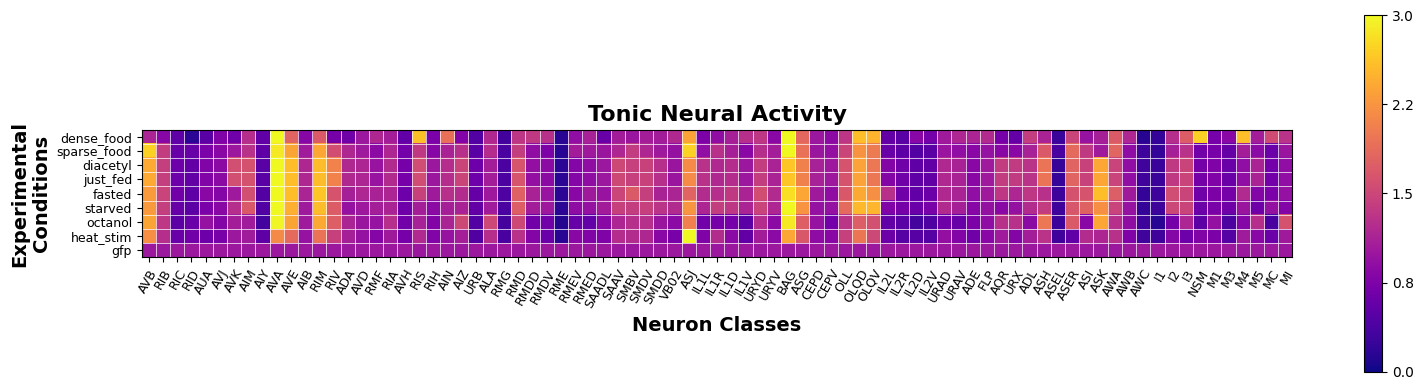

In [185]:
arr_F90 = dict_to_arr(dict_F90, 
                      all_conditions=all_conditions, 
                      all_neuron_classes=fig4_neuron_classes_found)

fig1, ax1, cbar1 = plot_heatmap(arr_F90 / arr_F90[-1], all_conditions, fig4_neuron_classes_found, 
                                clim=(0,3), xrotation=60, figsize=(16,4),
                                cmap='plasma', title='Tonic Neural Activity')
# plt.savefig('baseline_activity_f10.png')

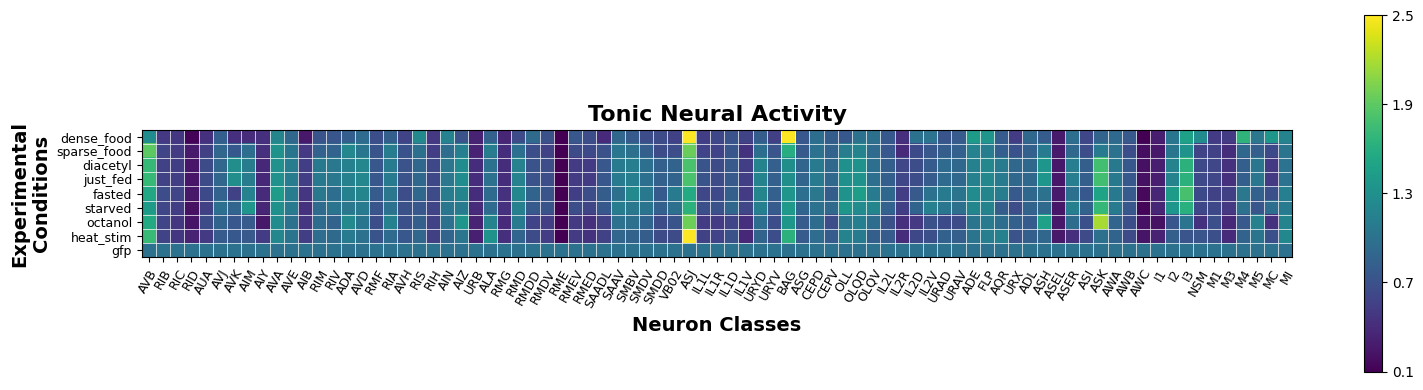

In [188]:
arr_F10 = dict_to_arr(dict_F10, 
                      all_conditions=all_conditions, 
                      all_neuron_classes=fig4_neuron_classes_found)

fig1, ax1, cbar1 = plot_heatmap(arr_F10 / arr_F10[-1], all_conditions, fig4_neuron_classes_found, 
                                clim=(0.1,2.5), xrotation=60, figsize=(16,4),
                                cmap='viridis', title='Tonic Neural Activity')
# plt.savefig('baseline_activity_f10.png')

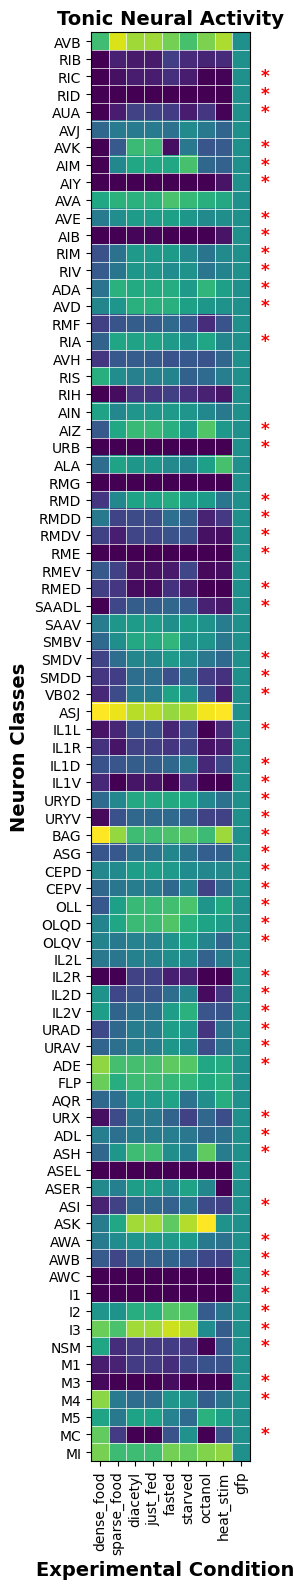

In [279]:
arr_F5 = dict_to_arr(dict_F5, 
                      all_conditions=all_conditions, 
                      all_neuron_classes=fig4_neuron_classes_found)

data = np.transpose(np.log2(arr_F5/ arr_F5[-1]))
result = kruskal_wallis_dict(dict_F5, drop_conditions=['gfp'])
corrected_result, significance = bonferroni_dict(result, alpha=0.01)

# fig1, ax1, cbar1 = plot_heatmap(np.log2(arr_F5/ arr_F5[-1]), all_conditions, fig4_neuron_classes_found, 
#                                 clim=(-1, 1), xrotation=90, figsize=(16,4),
#                                 cmap='viridis', title='Tonic Neural Activity',
#                                 sig_dict = significance
#                                )

vmin = -1
vmax = 1

fig1, ax1, cbar1 = plot_heatmap_transposed(data, fig4_neuron_classes_found, all_conditions, 
                                           clim=(vmin, vmax), cmap='viridis', 
                                           figsize=(4,16),
                                           title='Tonic Neural Activity',
                                           sig_dict = significance)

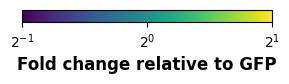

In [284]:
fig, ax = plt.subplots(figsize=(3, 2))

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# vmin/vmax in exponent space
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])

# Create horizontal colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Fold change relative to GFP', fontweight='bold', fontsize=12)

# Replace tick labels with 2^tick
ticks = [-1, 0, 1]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"$2^{{{t}}}$" for t in ticks], fontsize=10)

ax.set_visible(False)
plt.tight_layout()
plt.show()

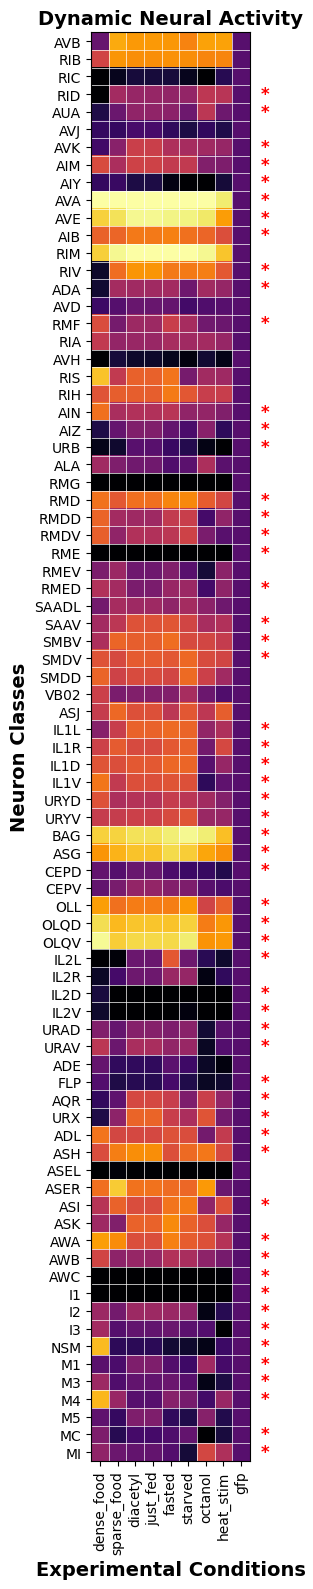

In [275]:
arr_sig = dict_to_arr(dict_signal, 
                      all_conditions=all_conditions, 
                      all_neuron_classes=fig4_neuron_classes_found)

result = kruskal_wallis_dict(dict_signal, drop_conditions=['gfp'])
corrected_result, significance = bonferroni_dict(result, alpha=0.01)

# data shape: (n_neurons, n_conditions)
data = np.transpose(np.log2(arr_sig/ arr_sig[-1]))

# fig, axes = plot_heatmap_transposed_with_padj(
#     data,
#     row_labels=fig4_neuron_classes_found,
#     col_labels=all_conditions,
#     adj_pvals_dict=corrected_result,
#     cmap='inferno', 
#     clim=(-1, 3), 
#     figsize=(4,16),
#     alpha=0.05,
#     title="Dynamic Neural Activity"
# )
# plt.show()


fig1, ax1, cbar1 = plot_heatmap_transposed(data, fig4_neuron_classes_found, all_conditions, 
                                clim=(-1, 3), 
                                           # xrotation=45, 
                                           figsize=(4,16),
                                cmap='inferno', title='Dynamic Neural Activity',
                                sig_dict = significance
                               )

# fig3, ax3, cbar3 = plot_heatmap(np.log2(arr_sig / arr_sig[-1]), all_conditions, fig4_neuron_classes_found, 
#                                 clim=(-1, 3), xrotation=90, figsize=(16,4),
#                                 cmap='inferno', title='Dynamic Neural Activity')
# plt.savefig('signal_std(Fmean).png')

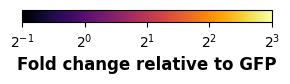

In [286]:
fig, ax = plt.subplots(figsize=(3, 2))

cmap = plt.cm.inferno.copy()
cmap.set_bad(color='white')

# vmin/vmax in exponent space
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=3))
sm.set_array([])

# Create horizontal colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Fold change relative to GFP', fontweight='bold', fontsize=12)

# Replace tick labels with 2^tick
ticks = [-1, 0, 1, 2, 3]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"$2^{{{t}}}$" for t in ticks], fontsize=10)

ax.set_visible(False)
plt.tight_layout()
plt.show()

/home/candy/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/candy/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


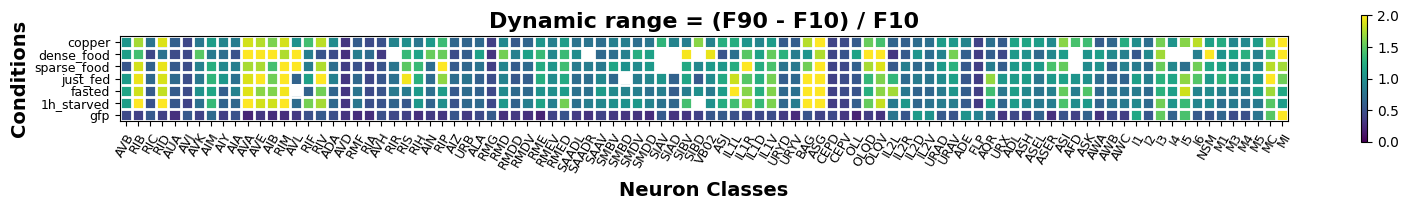

In [65]:
# arr_dr = dict_to_arr(dict_F10_F90, all_conditions=all_conditions, all_neuron_classes=fig4_neuron_classes)
# fig2, ax2, cbar2 = plot_heatmap(arr_dr, all_conditions, fig4_neuron_classes, 
#                                 clim=(0,2), xrotation=60, figsize=(16,2),
#                                   cmap='viridis', title='Dynamic range = (F90 - F10) / F10')
# plt.savefig('dynamic_range_f10_f90.png')